# Data Availability


EHBS data can be obtained by contacting Dr. Jim Lah at jlah@emory.edu.
ADNI data can be obtained from https://adni.loni.usc.edu/.
The dataset consists of peptides as columns and subjects as rows.


# Description
### EHBS dataset used to run EBM with feature clustering. Results replicated on ADNI dataset.

In [1]:
import os
import sys

In [2]:
# Change dir path to point to EBM
os.chdir("/Users/raghavtandon/Documents/PhD/ebm/ebm")
sys.path.append("/Users/raghavtandon/Documents/PhD/ebm/kde_ebm/")

In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from ebm import mixture_model
from ebm import mcmc
from kde_ebm import mixture_model as kde_mm
from kde_ebm import plotting as kde_plotting
from ebm import plotting
from ebm import datasets
from matplotlib import pyplot as plt
import numpy as np
import warnings
from collections import Counter
import pandas as pd
import analysis_functions as afunc
# from cross_sectional_simulation import simulation_scenarios
import time
import seaborn as sns
# from read_Lah_data import readData
# from partial_ranking_scores import pair_scores
from statannotations.Annotator import Annotator
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
def stage_histogram_asym(stages, y, max_stage=None, class_names=None):
    colors = ['C{}'.format(x) for x in range(10)]
    fig, ax = plt.subplots(figsize=(8, 4))
    hist_dat = [stages[y == 0],
                stages[y == 1],
                stages[y == 2]]
    if class_names is None:
        class_names = ['CN', 'AD', "AsymAD"]
    if max_stage is None:
        max_stage = stages.max()
    hist_c = colors[:3]
    n, bins, patch = ax.hist(hist_dat,
                             label=class_names,
                             density=False,
                             color=hist_c,
                             stacked=False,
                             bins=max_stage+1)
    ax.legend(loc=0, fontsize=20)

    idxs = np.arange(max_stage+2)
    bin_w = bins[1] - bins[0]
    ax.set_xticks(bins+bin_w/2)
    ax.set_xticklabels([str(x) for x in idxs], rotation=90)

    ax.set_ylabel('Fraction', fontsize=20)
    ax.set_xlabel('EBM Stage', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=13)
    fig.tight_layout()
    return fig, ax

In [5]:
scaledX, Ximp, label_df = afunc.readData()
scaledX.shape

(392, 75)

In [6]:
rfe_cn_ad = ['ADQDTIR',
 'IASNTQSR',
 'ELQAAQAR',
 'EPVAGDAVPGPK',
 'VVSSIEQK',
 'LGADMEDVCGR',
 'AQALEQAK',
 'YDNSLK']

In [7]:
scaledX, Ximp, label_df = afunc.readData()
scaledX = scaledX[rfe_cn_ad]
dx = ["Control", "AD"]
X_cnad, y_cnad = afunc.extract_classes(scaledX, label_df, dx)
X, y = afunc.extract_classes(scaledX, label_df, dx)
y = y.map({"Control":0, "AD":1}).to_numpy()
bm_names = scaledX.columns.tolist()
cname = ["CN", "AD"]

In [8]:
mixture_type = "gmm"
if mixture_type=="kde":
    mm = kde_mm
    mm_fit = mm.fit_all_kde_models
elif mixture_type == "gmm":
    mm = mixture_model
    mm_fit = mm.fit_all_gmm_models

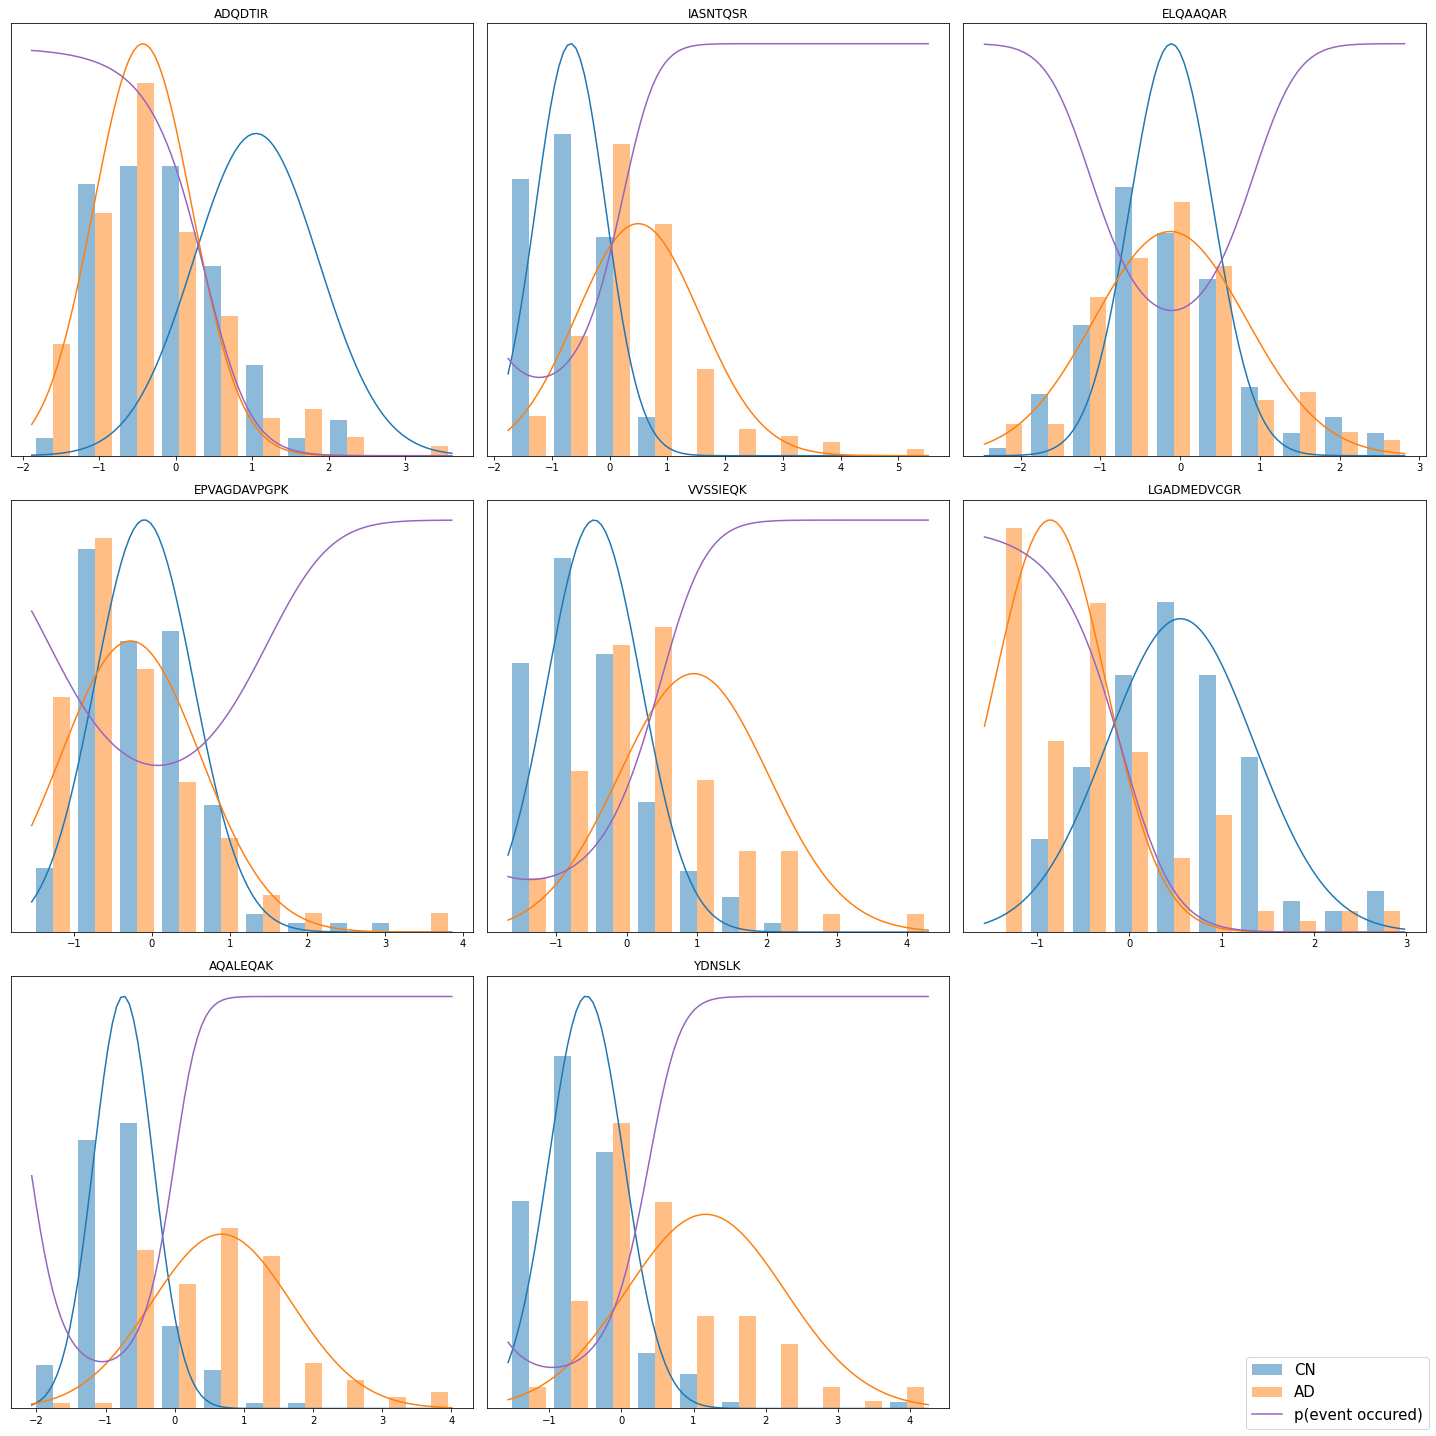

In [9]:
mixture_models_full = mm_fit(X, y) 
fig, ax = plotting.mixture_model_grid(X, y, mixture_models_full, score_names=bm_names, class_names=cname)

## Run Params

In [10]:
add_noise = False
noise_dim=15
bm_names = scaledX.columns.tolist()
if add_noise:
    noise = np.random.multivariate_normal(np.zeros(noise_dim), np.eye(noise_dim), size=X.shape[0])
    X_ebm = np.hstack([X, noise])
    bm_names += ["noise{}".format(_) for _ in range(1,noise_dim+1)]
else:
    X_ebm = X

In [11]:
print("Starting shape for X (includin all features, noise, etc.)", X_ebm.shape)

Starting shape for X (includin all features, noise, etc.) (262, 8)


### Exclude peptides which show zero probabilities for some individuals

In [12]:
prob_mat = mixture_model.get_prob_mat(X_ebm, mixture_models_full)
bm_keep, bm_remove = afunc.zero_bm(prob_mat, bm_names, 0)
X_ebm = X_ebm[:,bm_keep]
bm_names_ebm = [bm_names[_] for _ in bm_keep]
print("Final shape for X", X_ebm.shape)

Final shape for X (262, 8)


In [13]:
print("Size of input X", X_ebm.shape)
fs=False
nclust = [2,2,2,2]
assert sum(nclust) == len(bm_names_ebm) == X_ebm.shape[1]

Size of input X (262, 8)


# Fit sEBM

Event Class -  custom


100% |########################################################################|


Iter -  (392, 75)
Time -  299.70801997184753


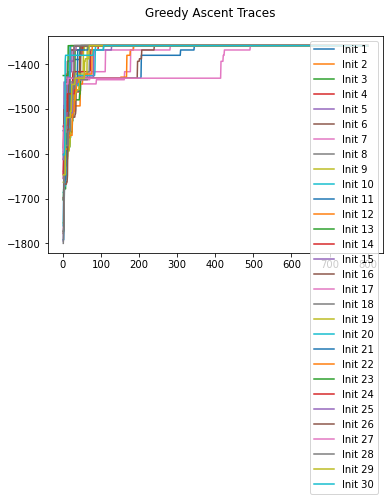

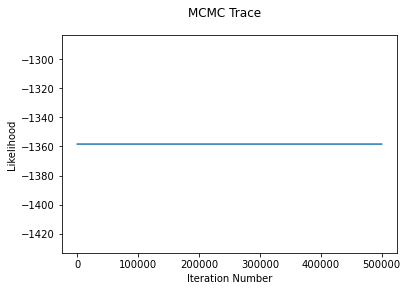

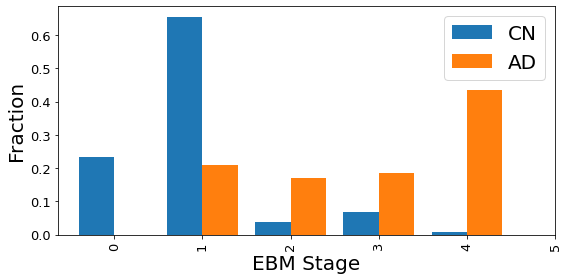

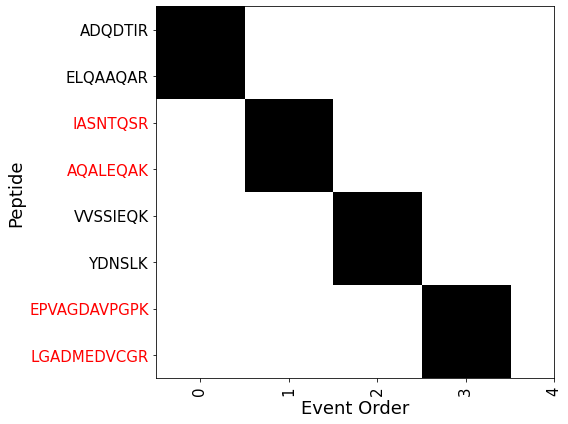

In [14]:
a = time.time()
# well-separable CN/AD
#res_equal = mcmc.mcmc(X, mixture_models, nclust, n_iter=100000, greedy_n_iter=3000, greedy_n_init=20, fs=fs)
mixture_models_mcmc = mm_fit(X_ebm, y)
res_equal = mcmc.mcmc(X_ebm, mixture_models_mcmc, nclust=nclust, n_iter=500000, greedy_n_iter=800, greedy_n_init=30, fs=fs)
plotting.mcmc_trace(res_equal, False)
res_equal.sort(reverse=True)
ml_order = res_equal[0]
#ranking_error = pair_scores(gt_order, ml_order.ordering, 0.5)
#ordering_error = ranking_error/max_error
prob_mat = mm.get_prob_mat(X_ebm, mixture_models_mcmc)
stages, stages_like = ml_order.stage_data(prob_mat)
fig, ax = plotting.stage_histogram(stages, y, )
b = time.time()
fig, ax = plotting.mcmc_clust_uncert_mat(res_equal[:200000], score_names=bm_names)
print("Iter - ",_)
#print("Kendall-Tau error - ", ordering_error)
print("Time - ",b-a)

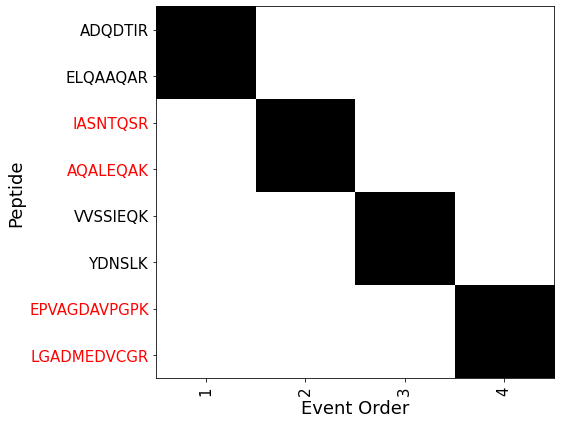

In [15]:
ax.set_xticklabels([1,2,3,4])
ax.set_xlabel("Event Order")
ax.set_xlim([-0.5,3.5])
fig

In [16]:
fig.savefig("/Users/raghavtandon/Documents/PhD/multi-modal/figures_publication/sEBM_figures/uncertain_mat2.png", dpi=500, transparent=True)

In [17]:
## Cluster modules
# clust_codes = ml_order.ordering
# clust_peptides = {}
# clust_modules = {}
# for k, v in clust_codes.items():
#     clust_peptides[k] = [bm_names_ebm[_] for _ in v]

# pep_codes = pd.read_csv("/Users/raghavtandon/Documents/PhD/multi-modal/data/peptide_protein_links.csv")

# Counter(pep_codes["module"])
# for i in range(len(clust_codes)):
#     clust_modules[i] = dict(Counter(pep_codes[pep_codes["peptide"].isin(clust_peptides[i])]["module"]))
# clust_modules

## Overlay the AsymAD cases

In [18]:
X_asym, y_asym = afunc.extract_classes(scaledX, label_df, ["AsymAD"])
X_asym_subset = X_asym[:, bm_keep]
X_cnad_subset = X_cnad[:, bm_keep]

In [19]:
# Create the stages for the AsymAD subjects - 
# 1. CReate the prob_mat_asym
# 2. Pass that prob_mat_asym to staging function
mixture_models_subset = [mixture_models_full[i] for i in bm_keep]
prob_mat_asym_subset = mixture_model.get_prob_mat(X_asym_subset, mixture_models_subset)
stages_asym, stages_like_asym = ml_order.stage_data(prob_mat_asym_subset)

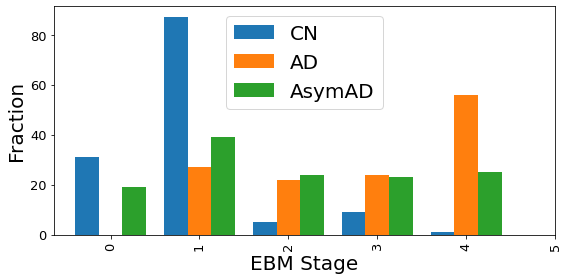

In [20]:
stages_total = np.concatenate([stages, stages_asym])
y_total = np.concatenate([y, y_asym.map({"AsymAD":2}).to_numpy()])
fig, ax = stage_histogram_asym(stages_total, y_total)
# fig.savefig("staging.png", dpi=600)

In [21]:
y_asym_df =pd.DataFrame(y_asym)
y_asym_df["stage"] = stages_asym
asym_strat = pd.read_csv("/Users/raghavtandon/Documents/PhD/multi-modal/data/final_viz_dataframe_guid.csv", usecols=["sbj", "DX", "predicted_final"])
asym_strat = asym_strat[asym_strat["DX"].isin(["ASYMAD"])].set_index("sbj")
y_strat = y_asym_df.merge(asym_strat, left_index=True, right_index=True, how="inner")[["stage", "predicted_final"]]
y_strat = y_strat.groupby(["stage", "predicted_final"]).size().reset_index()
y_strat["predicted_final"] = y_strat["predicted_final"].map({"AD-like ASYMAD":"AD-like AsymAD", "Control-like ASYMAD":"Control-like AsymAD"})

In [22]:
y_strat

,stage,predicted_final,0
0,0,AD-like AsymAD,2
1,0,Control-like AsymAD,17
2,1,AD-like AsymAD,13
3,1,Control-like AsymAD,26
4,2,AD-like AsymAD,14
5,2,Control-like AsymAD,10
6,3,AD-like AsymAD,14
7,3,Control-like AsymAD,9
8,4,AD-like AsymAD,21
9,4,Control-like AsymAD,4


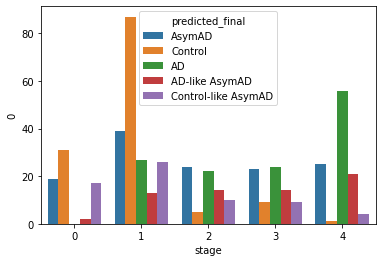

In [23]:
concat_df = pd.concat([pd.Series(stages_total), pd.Series(y_total).map({0:"Control",1:"AD",2:"AsymAD"})],axis=1)
concat_df.columns = ["stage", "predicted_final"]
cn_ad_counts = concat_df.groupby(["stage", "predicted_final"]).size().reset_index()
final_counts = pd.concat([cn_ad_counts,y_strat],axis=0)
sns.barplot(data=final_counts, x="stage", y=0, hue="predicted_final")

In [24]:
xx = concat_df[concat_df["predicted_final"].isin(["Control", "AD"])]

In [25]:
y_asym_df =pd.DataFrame(y_asym)
y_asym_df["stage"] = stages_asym
asym_strat = pd.read_csv("/Users/raghavtandon/Documents/PhD/multi-modal/data/final_viz_dataframe_guid.csv", usecols=["sbj", "DX", "predicted_final"])
asym_strat = asym_strat[asym_strat["DX"].isin(["ASYMAD"])].set_index("sbj")
y_strat = y_asym_df.merge(asym_strat, left_index=True, right_index=True, how="inner")[["stage", "predicted_final"]]
y_strat

,stage,predicted_final
sbj,,
S004_B1A04_64428,1,AD-like ASYMAD
S005_B1A05_66661,4,AD-like ASYMAD
S010_B1A10_55499,3,Control-like ASYMAD
S012_B1B02_68460,0,Control-like ASYMAD
S016_B1B06_61827,2,AD-like ASYMAD
...,...,...
S386_B5G05_71938,1,Control-like ASYMAD
S390_B5G09_69224,0,Control-like ASYMAD
S393_B5H02_72982,1,Control-like ASYMAD


In [26]:
ehbs_stages = pd.concat([xx, y_strat], axis=0).reset_index()
del ehbs_stages["index"]

In [27]:
final_counts.pivot(columns="predicted_final", values=0, index="stage")

predicted_final,AD,AD-like AsymAD,AsymAD,Control,Control-like AsymAD
stage,,,,,
0,NaN,2.0,19.0,31.0,17.0
1,27.0,13.0,39.0,87.0,26.0
2,22.0,14.0,24.0,5.0,10.0
3,24.0,14.0,23.0,9.0,9.0
4,56.0,21.0,25.0,1.0,4.0


In [28]:
counts_pivot = cn_ad_counts.pivot(columns="predicted_final", index="stage", values=0).fillna(0)
counts_pivot /= counts_pivot.sum(axis=0)
counts_bar = counts_pivot.melt(ignore_index=False, value_vars=["Control","AD","AsymAD"]).reset_index()

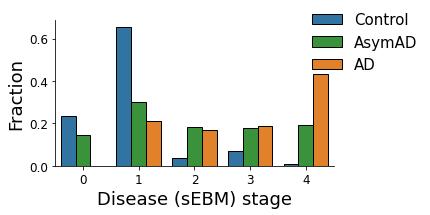

In [29]:
fig, ax = plt.subplots(figsize=(6,3))
hue_order=["Control", "AsymAD", "AD"]
palette = ["C0", "C2","C1"]
sns.barplot(data=counts_bar, x="stage", y="value", 
            hue="predicted_final",ax=ax, hue_order=hue_order, 
            palette=palette,edgecolor="k",linewidth=1)
ax.set_xlabel("Disease (sEBM) stage", fontsize=18)
ax.set_ylabel("Fraction", fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(title="", fontsize=15, framealpha=0.0, loc=(0.9,0.6))
# ax.text(s=r"p-value ($\chi^{2}$) < 1 x $10^{-18}$ ",x=1.0,y=0.5, fontsize=15)
sns.despine()
plt.tight_layout()
# fig.savefig("/Users/raghavtandon/Documents/PhD/multi-modal/figures_publication/sEBM_figures/Asym_strat_sEBM_ANA.png", dpi=600, transparent=True)


In [30]:
counts_pivot = final_counts.pivot(columns="predicted_final", index="stage", values=0).fillna(0)
counts_pivot /= counts_pivot.sum(axis=0)
counts_bar = counts_pivot.melt(ignore_index=False, value_vars=["Control","AD","AD-like AsymAD", "Control-like AsymAD"]).reset_index()

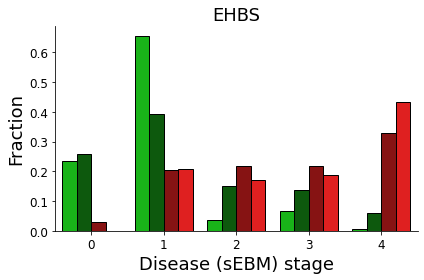

In [31]:
fig, ax = plt.subplots(figsize=(6,4))
hue_order=["Control", "Control-like AsymAD", "AD-like AsymAD", "AD"]
palette = ["#00CC00", "#006600", "#990000","#FF0000"]
sns.barplot(data=counts_bar, x="stage", y="value", 
            hue="predicted_final",ax=ax, hue_order=hue_order, 
            palette=palette,edgecolor="k",linewidth=1)
ax.set_xlabel("Disease (sEBM) stage", fontsize=18)
ax.set_ylabel("Fraction", fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(title="", fontsize=15, framealpha=0.0)
ax.get_legend().remove()
# ax.text(s=r"p-value ($\chi^{2}$) < 1 x $10^{-5}$ ",x=1.2,y=0.3, fontsize=15)
# ax.text(s=r"p-value < 1 x $10^{-5}$ ",x=1.2,y=0.3, fontsize=15)
ax.set_title("EHBS", fontsize=18)
sns.despine()
plt.tight_layout()
# fig.savefig("/Users/raghavtandon/Documents/PhD/multi-modal/figures_publication/sEBM_figures/Asym_strat_sEBM.png", dpi=600, transparent=True)


# ADNI data

In [69]:
"""
This is the data/file used for publication figures in Nat Comm submission
# path="/Users/raghavtandon/Documents/PhD/multi-modal/data/ADNI/adni_followup_matched_av45.csv"
# col_name = "fdg_progression"
# map_dict = {"NO":0,"YES":1}
"""
path="/Users/raghavtandon/Documents/PhD/multi-modal/data/ADNI/adni_followup_matched_av45.csv"
col_name = "fdg_progression"
map_dict = {"NO":0,"YES":1}
def read_adni(path):
    df_adni = pd.read_csv(path, index_col=0)
    old_cols = df_adni.columns[36:].tolist()
    new_cols = [x.split(";")[-1] for x in old_cols]
    rename_dict = dict(zip(old_cols, new_cols))
    df_adni.rename(columns=rename_dict, inplace=True)
    return df_adni

In [70]:
# Complete data - AD, CN, AsymAD
df_adni = read_adni(path)
# Scale all data
ss = StandardScaler()
x_adni_all = ss.fit_transform(df_adni[rfe_cn_ad])
x_adni_all = pd.DataFrame(x_adni_all, columns=rfe_cn_ad)
x_adni_all["DX"] = df_adni["DX"].reset_index(drop=True)
# CN and AD
df_adni_cnad = x_adni_all[x_adni_all["DX"].isin(["Control", "AD"])]
y_adni_cnad = df_adni_cnad["DX"]
# AsymAD
df_adni_asym = x_adni_all[x_adni_all["DX"].isin(["AsymAD"])]
y_adni_asym = df_adni_asym["DX"]
fdg_asym = df_adni[df_adni["DX"].isin(["AsymAD"])][col_name].map(map_dict)
# fdg_asym = df_adni_asym[col_name].map(map_dict)
# features for full data
y_adni = df_adni["DX"]

In [71]:
x_adni_cnad = df_adni_cnad[rfe_cn_ad].values
x_adni_asym = df_adni_asym[rfe_cn_ad].values

In [72]:
mixture_models_full = mm_fit(x_adni_cnad, y_adni_cnad.map({"AD":1, "Control":0}))

In [73]:
# Create the stages for the AsymAD subjects - 
# 1. Create the prob_mat_asym
# 2. Pass that prob_mat_asym to staging function
mixture_models_subset = [mixture_models_full[i] for i in bm_keep]
prob_mat_adni_subset = mixture_model.get_prob_mat(np.concatenate([x_adni_cnad, x_adni_asym], axis=0),
                                                  mixture_models_subset)
stages_adni, stages_like_adni = ml_order.stage_data(prob_mat_adni_subset)
Counter(stages_adni)

Counter({4: 84, 0: 45, 1: 18, 3: 8, 2: 1})

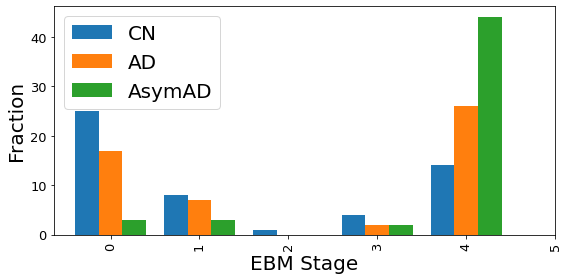

In [74]:
fig, ax = stage_histogram_asym(stages_adni, y_adni.map({"AD":1, "Control":0, "AsymAD":2}))

In [75]:
adni_counters_asym = pd.concat([y_adni_asym.reset_index(drop=True), fdg_asym.reset_index(drop=True)], axis=1)
adni_counters_asym["stages"] = stages_adni[-y_adni_asym.shape[0]:]
adni_counters_asym["DX"] =  adni_counters_asym[col_name].apply(lambda x: "Control-like AsymAD" if x == 0 else "AD-like AsymAD")
adni_counters_asym = adni_counters_asym[["DX", "stages"]]
# adni_final_counters = pd.concat([adni_counters_asym, adni_counters_cnad], axis=0)


In [76]:
# adni_counters_asym = pd.concat([y_adni_asym, fdg_asym], axis=1)
# adni_counters_asym["stages"] = stages_adni[-y_adni_asym.shape[0]:]
# adni_counters_asym["DX"] =  adni_counters_asym[col_name].apply(lambda x: "Control-like AsymAD" if x == 0 else "AD-like AsymAD")
# adni_counters_asym = adni_counters_asym[["DX", "stages"]]
# # adni_final_counters = pd.concat([adni_counters_asym, adni_counters_cnad], axis=0)


In [77]:
adni_counters_cnad = pd.DataFrame(y_adni_cnad)
adni_counters_cnad["stages"] = stages_adni[:-y_adni_asym.shape[0]]
adni_final_counters = pd.concat([adni_counters_cnad, adni_counters_asym], axis=0)
adni_final_counts = adni_final_counters.groupby(["stages", "DX"]).size().reset_index()

In [78]:
df_adni_cnad

,ADQDTIR,IASNTQSR,ELQAAQAR,EPVAGDAVPGPK,VVSSIEQK,LGADMEDVCGR,AQALEQAK,YDNSLK,DX
0,0.293547,0.902948,-0.231043,0.134095,1.850269,0.841988,-0.443912,2.965191,Control
1,1.414480,0.216218,1.575648,1.723759,-0.617335,1.948075,-0.576123,-0.307323,Control
2,-0.761448,-0.899718,-0.382589,-0.905097,-0.897965,0.612462,-0.330588,-0.634574,Control
3,0.557296,-0.542486,-0.117541,0.804541,-0.085107,0.715282,-0.141715,-0.634574,Control
4,-0.959260,-1.054232,-1.169625,-0.386383,-1.178594,-0.551785,-1.596038,-0.307323,Control
...,...,...,...,...,...,...,...,...,...
151,-0.365825,-0.978296,-0.737441,-0.262880,0.408414,-0.935021,0.519340,-1.289077,AD
152,-0.299888,-0.373445,0.321504,-0.368740,2.856665,1.221070,0.557115,1.983437,AD
153,-0.431762,0.438084,-0.195496,-0.636918,-0.404444,-0.710688,-0.991644,0.019929,AD
154,-1.420821,-1.695400,-1.894921,-1.430868,0.050369,-0.667067,-0.953869,0.347180,AD


In [82]:
# pd.concat([df_adni_cnad, df_adni_asym],axis=0)
pd.concat([df_adni_cnad, df_adni_asym],axis=0).shape
# adni_final_counters

(156, 9)

In [83]:
adni_final_counts.pivot(columns="DX", values=0, index="stages")

DX,AD,AD-like AsymAD,Control,Control-like AsymAD
stages,,,,
0,3.0,1.0,25.0,16.0
1,3.0,1.0,8.0,6.0
2,NaN,NaN,1.0,NaN
3,2.0,NaN,4.0,2.0
4,44.0,8.0,14.0,18.0


In [85]:
adni_stages = pd.concat([adni_counters_cnad, adni_counters_asym], axis=0).reset_index()
# del adni_stages["RID"]

In [86]:
counts_pivot = adni_final_counts.pivot(columns="DX", index="stages", values=0).fillna(0)
counts_pivot /= counts_pivot.sum(axis=0)
counts_bar = counts_pivot.melt(ignore_index=False, value_vars=["Control","AD","AD-like AsymAD", "Control-like AsymAD"]).reset_index()

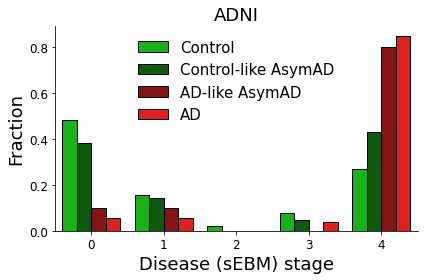

In [87]:
fig, ax = plt.subplots(figsize=(6,4))
hue_order=["Control", "Control-like AsymAD", "AD-like AsymAD", "AD"]
palette = ["#00CC00", "#006600", "#990000","#FF0000"]
sns.barplot(data=counts_bar, x="stages", y="value", 
            hue="DX",ax=ax, hue_order=hue_order, 
            palette=palette,edgecolor="k",linewidth=1)
ax.set_xlabel("Disease (sEBM) stage", fontsize=18)
ax.set_ylabel("Fraction", fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(title="", fontsize=15, framealpha=0.0)
# ax.text(s=r"p-value = 0.04",x=0.5,y=0.3, fontsize=15)
ax.set_title("ADNI", fontsize=18)
sns.despine()
plt.tight_layout()
# fig.savefig("/Users/raghavtandon/Documents/PhD/multi-modal/figures_publication/sEBM_figures/Asym_strat_sEBM_ADNI_AV45.png", dpi=600, transparent=True)

In [88]:
X_ehbs = pd.DataFrame(np.concatenate([X_ebm, X_asym],axis=0), columns=bm_names)
X_ehbs = pd.concat([X_ehbs, ehbs_stages], axis=1)


In [89]:
ml_bm_order = []
for i, j in ml_order.ordering.items():
    ml_bm_order.append(j)
ml_bm_order = np.hstack(ml_bm_order)
bm_ebm_order = [bm_names[_] for _ in ml_bm_order]

In [90]:
bm_ebm_order

['ADQDTIR',
 'ELQAAQAR',
 'IASNTQSR',
 'AQALEQAK',
 'VVSSIEQK',
 'YDNSLK',
 'EPVAGDAVPGPK',
 'LGADMEDVCGR']

In [91]:
stages_adni.shape

(156,)

# Distributions of stage specific peptides in the EHBS dataset

p-value annotation legend:
      ns: 1.00e-04 < p <= 1.00e+00
       *: 1.00e-06 < p <= 1.00e-04
      **: 1.00e-08 < p <= 1.00e-06
     ***: 1.00e-10 < p <= 1.00e-08
    ****: p <= 1.00e-10

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:7.043e-26 U_stat=7.619e+03
1 vs. 2: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:2.897e-07 U_stat=2.028e+03
2 vs. 3: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:7.689e-07 U_stat=6.350e+02
3 vs. 4: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:1.811e-04 U_stat=3.160e+03
p-value annotation legend:
      ns: 1.00e-04 < p <= 1.00e+00
       *: 1.00e-06 < p <= 1.00e-04
      **: 1.00e-08 < p <= 1.00e-06
     ***: 1.00e-10 < p <= 1.00e-08
    ****: p <= 1.00e-10

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:2.443e-13 U_stat=6.466e+03
1 vs. 2: Mann-Whitney-Wilcoxon test two-sided with Holm-

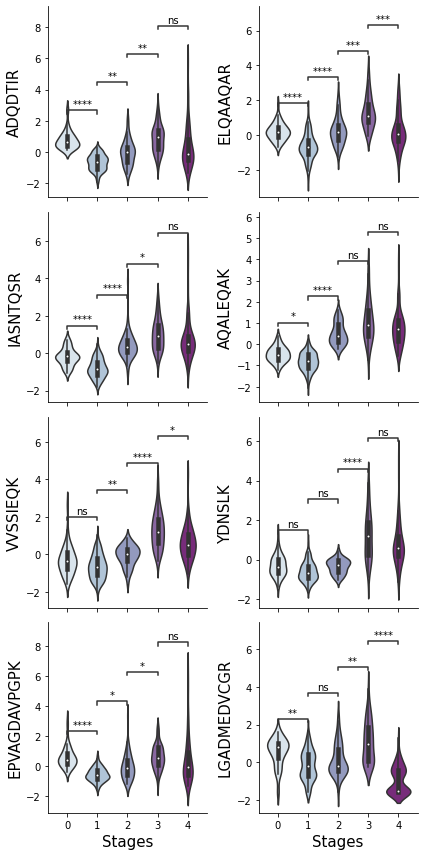

In [92]:
fig, ax = plt.subplots(4,2, sharex=True, sharey=False, figsize=(6,12))
pairs = [(0,1),(1,2),(2,3),(3,4)]

for i, bm_i in enumerate(bm_ebm_order):
    r = i // 2
    c = i % 2
    sns.violinplot(data=X_ehbs, 
                   x="stage", y=bm_i, ax=ax[r, c],
                  palette="BuPu", density_norm="Count")
    ax[r,c].set_ylabel(bm_i, fontsize=15)
    ax[r,c].set_xlabel("")
    ax[r,c].spines['right'].set_visible(False)
    ax[r,c].spines['top'].set_visible(False)
    annotator = Annotator(ax[r,c], pairs, data=X_ehbs, x="stage", y=bm_i)
    annotator._pvalue_format.pvalue_thresholds =  [[1e-4, '*'], [1e-6, '**'], [1e-8, '***'], [1e-10, '****'], [1, 'ns']]
    annotator.configure(test='Mann-Whitney', text_format='star', 
                        loc='inside',comparisons_correction="Holm-Bonferroni")
    annotator.apply_and_annotate()

ax[3,0].set_xlabel("Stages", fontsize=15)
ax[3,1].set_xlabel("Stages", fontsize=15)
fig.tight_layout()
fig.savefig("/Users/raghavtandon/Documents/PhD/multi-modal/figures_publication/sEBM_figures/ehbs_ebm_violins.png", dpi=600, transparent=True)
    

In [93]:
X_adni = pd.DataFrame(np.concatenate([x_adni_cnad, x_adni_asym],axis=0), columns=bm_names)
X_adni = pd.concat([X_adni, adni_stages], axis=1)
X_adni.rename(columns={"stages":"stage"},inplace=True)

p-value annotation legend:
      ns: 1.00e-04 < p <= 1.00e+00
       *: 1.00e-06 < p <= 1.00e-04
      **: 1.00e-08 < p <= 1.00e-06
     ***: 1.00e-10 < p <= 1.00e-08
    ****: p <= 1.00e-10

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:8.688e-09 U_stat=7.835e+02
1 vs. 2: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:1.401e-01 U_stat=5.000e-01
2 vs. 3: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:3.289e-01 U_stat=1.000e+00
3 vs. 4: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:1.180e-05 U_stat=6.525e+02
p-value annotation legend:
      ns: 1.00e-04 < p <= 1.00e+00
       *: 1.00e-06 < p <= 1.00e-04
      **: 1.00e-08 < p <= 1.00e-06
     ***: 1.00e-10 < p <= 1.00e-08
    ****: p <= 1.00e-10

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:5.492e-03 U_stat=5.880e+02
1 vs. 2: Mann-Whitney-Wilcoxon test two-sided with Holm-

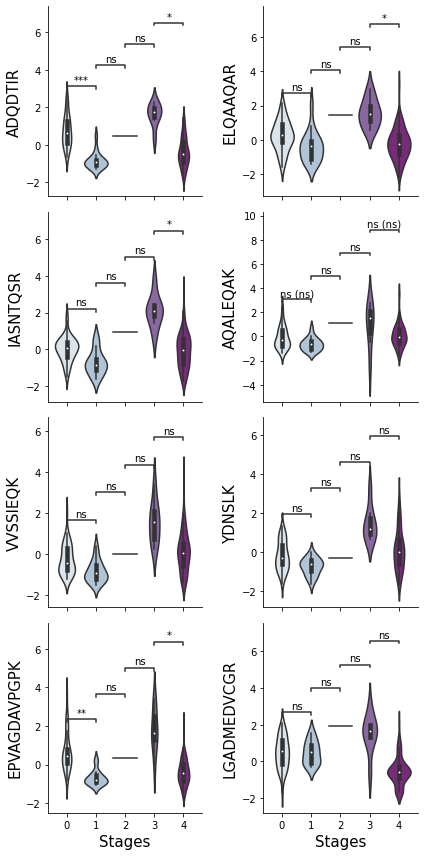

In [94]:
fig, ax = plt.subplots(4,2, sharex=True, sharey=False, figsize=(6,12))
for i, bm_i in enumerate(bm_ebm_order):
    r = i // 2
    c = i % 2
    sns.violinplot(data=X_adni, 
                   x="stage", y=bm_i, ax=ax[r, c],
                  palette="BuPu")
    ax[r,c].set_ylabel(bm_i, fontsize=15)
    ax[r,c].set_xlabel("")
    ax[r,c].spines['right'].set_visible(False)
    ax[r,c].spines['top'].set_visible(False)
    annotator = Annotator(ax[r,c], pairs, data=X_adni, x="stage", y=bm_i)
    annotator._pvalue_format.pvalue_thresholds =  [[1e-4, '*'], [1e-6, '**'], [1e-8, '***'], [1e-10, '****'], [1, 'ns']]
    annotator.configure(test='Mann-Whitney', text_format='star', 
                        loc='inside',comparisons_correction="Holm-Bonferroni")
    annotator.apply_and_annotate()

ax[3,0].set_xlabel("Stages", fontsize=15)
ax[3,1].set_xlabel("Stages", fontsize=15)
fig.tight_layout()
# fig.savefig("/Users/raghavtandon/Documents/PhD/multi-modal/figures_publication/sEBM_figures/adni_ebm_violins.png", dpi=600, transparent=True)
    
    

In [96]:
matched_path = "/Users/raghavtandon/Documents/PhD/multi-modal/data/EHBS-2-210611/Matched Cases - De-Ident.csv"
matched_df = pd.read_csv(matched_path)

In [97]:
ehbs_labels = pd.concat([y_cnad, y_asym], axis=0).reset_index()
ehbs_labels["GUID"] = ehbs_labels["sbj"].apply(lambda x: int(x.split("_")[-1]))
ehbs_labels = pd.concat([ehbs_labels, ehbs_stages], axis=1)

In [99]:
ehbs_patho_df = pd.merge(matched_df, ehbs_labels, left_on="GUID", right_on="GUID", how="inner")

In [100]:
ehbs_patho_df["tTau:pTau"] = ehbs_patho_df["tTau"]/ehbs_patho_df["pTau"]
ehbs_patho_df["pTau:A_42"] = ehbs_patho_df["pTau"]/ehbs_patho_df["A_42"]

# Markers of pathology and their distribution over the stages

p-value annotation legend:
      ns: 1.00e-04 < p <= 1.00e+00
       *: 1.00e-06 < p <= 1.00e-04
      **: 1.00e-08 < p <= 1.00e-06
     ***: 1.00e-10 < p <= 1.00e-08
    ****: p <= 1.00e-10

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:2.849e-05 U_stat=5.333e+03
1 vs. 2: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:1.549e-03 U_stat=5.058e+03
2 vs. 3: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:9.866e-04 U_stat=8.995e+02
3 vs. 4: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:1.392e-07 U_stat=3.511e+03
p-value annotation legend:
      ns: 1.00e-04 < p <= 1.00e+00
       *: 1.00e-06 < p <= 1.00e-04
      **: 1.00e-08 < p <= 1.00e-06
     ***: 1.00e-10 < p <= 1.00e-08
    ****: p <= 1.00e-10

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided with Holm-Bonferroni correction, P_val:1.041e-04 U_stat=5.225e+03
1 vs. 2: Mann-Whitney-Wilcoxon test two-sided with Holm-

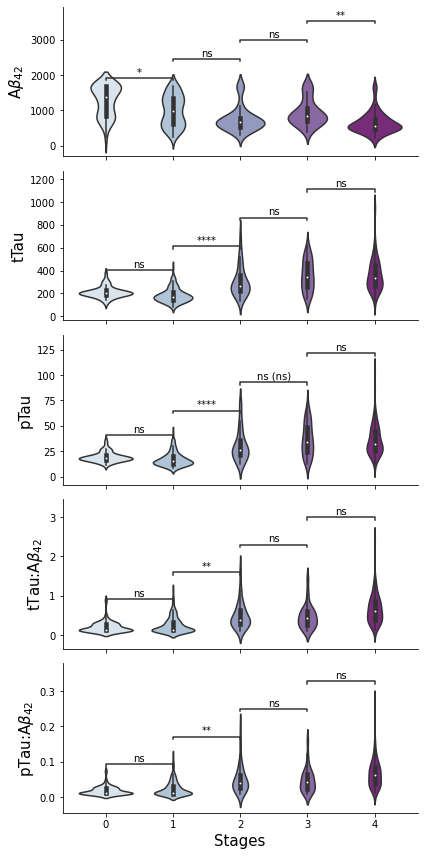

In [102]:
fig, ax = plt.subplots(5,1, sharex=True, sharey=False, figsize=(6,12))
patho_list = ["A_42", "tTau", "pTau", "tTau:A_42", "pTau:A_42"]
name_dict = {"A_42":r'A$\beta_{42}$', "tTau":"tTau", "pTau":"pTau", "tTau:A_42":r'tTau:A$\beta_{42}$',
            "pTau:A_42":r'pTau:A$\beta_{42}$'}
pairs = [(0,1),(1,2),(2,3),(3,4)]
for i, bm_i in enumerate(patho_list):
    sns.violinplot(data=ehbs_patho_df, 
                   x="stage", y=bm_i, ax=ax[i],
                  palette="BuPu")
    ax[i].set_ylabel(name_dict[bm_i],
                     fontsize=15)
    ax[i].set_xlabel("")
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    annotator = Annotator(ax[i], pairs, data=ehbs_patho_df, x="stage", y=bm_i)
    annotator._pvalue_format.pvalue_thresholds =  [[1e-4, '*'], [1e-6, '**'], [1e-8, '***'], [1e-10, '****'], [1, 'ns']]
    annotator.configure(test='Mann-Whitney', text_format='star', 
                        loc='inside',comparisons_correction="Holm-Bonferroni")
    annotator.apply_and_annotate()

ax[4].set_xlabel("Stages", fontsize=15)
fig.tight_layout()
fig.savefig("/Users/raghavtandon/Documents/PhD/multi-modal/figures_publication/sEBM_figures/ehbs_patho_violins.png", dpi=600, transparent=True)
    
    